In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import xgcm
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter

import warnings
warnings.filterwarnings('ignore')

In [2]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/channel.yaml")


In [38]:
import os
SCRATCH_BUCKET = os.environ['SCRATCH_BUCKET']
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [3]:
ds = cat['run_tracers_restored_zarr'].to_dask()


In [4]:
ds = ds.chunk({'time':1})

In [5]:
import sys
sys.path.append('../../modules/')
import filter_coarsen_func as fcf
import MITgcm_advection_schemes as MITadv

In [43]:
Lfilter = np.array([400e3, 200e3, 100e3, 50e3] )
dx = 5e3
coarsen_factor = 5
#coarsen_points= int(Lfilter/coarsen_factor/dx)

In [44]:
da_mask = ds.maskC.astype('float')

In [66]:
ds_all_masks = {}
for L in Lfilter:
    # Create a mask that has no land (so we can use apply_gcm_filter)
    coarsen_point = int(L/coarsen_factor/dx)
    
    wet_mask = xr.DataArray(np.ones((400,400)), dims=['YC', 'XC'])

    da_mask_filt = fcf.apply_gcm_filter(da_mask, L, dx, wet_mask)
    da_mask_filt_coarse = fcf.coarsen_MITgcm_datarray(da_mask_filt, coarsen_point)
    
    res= str(int(L/1e3))
    
    ds_all_masks[res] = da_mask_filt_coarse.drop_vars('maskC')

In [68]:
from datatree import DataTree
ds_all_masks =  DataTree.from_dict(ds_all_masks)

In [71]:
ds_all_masks.to_zarr(f'{PERSISTENT_BUCKET}/ML_data/ds_ML_masks', 
                                                  mode='w')

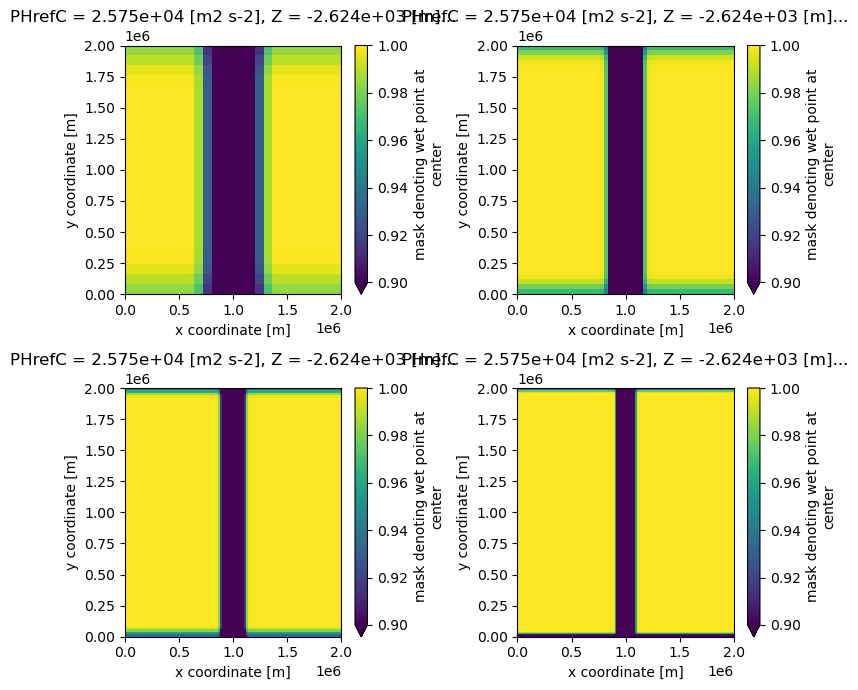

In [82]:
plt.figure(figsize=(8,7))
plt.subplot(221)
ds_all_masks['400'].ds.maskC.isel(Z=36).plot(vmin=0.9)

plt.subplot(222)
ds_all_masks['200'].ds.maskC.isel(Z=36).plot(vmin=0.9)

plt.subplot(223)
ds_all_masks['100'].ds.maskC.isel(Z=36).plot(vmin=0.9)

plt.subplot(224)
ds_all_masks['50'].ds.maskC.isel(Z=36).plot(vmin=0.9)

plt.tight_layout()